In [1]:
import sys
import numpy as np
import os
from os.path import abspath

import matplotlib.pyplot as plt
%matplotlib inline
import subtle.subtle_io as suio

# import subtle.subtle_preprocess as sup
import subtle.subtle_plot as suplot
import nibabel as nib
import nipype
from nipype.interfaces import fsl
import nipype.interfaces.io

from niwidgets import NiftiWidget
# NiftiWidget(_x0).nifti_plotter()

from IPython.display import Image
print(fsl.Info().version())


Using TensorFlow backend.
/home/subtle/tensorflow/lib/python3.5/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


6.0.0


In [2]:
working_dir = '/raid/jon/data_full_hoag/data/101_Id_066study'

In [3]:
nib_files = []
for filename in os.listdir(working_dir):
    if ".nii" in filename.lower():
        nib_files.append(os.path.join(working_dir,filename))
order = np.argsort([int(os.path.basename(l).split('_')[0]) for l in nib_files])
nib_files = list(np.array(nib_files)[order])
print(nib_files)

['/raid/jon/data_full_hoag/data/101_Id_066study/2_sag_mprage.nii.gz', '/raid/jon/data_full_hoag/data/101_Id_066study/13_sag_mprage_we_10_percent.nii.gz', '/raid/jon/data_full_hoag/data/101_Id_066study/14_sag_mprage_we_post.nii.gz']


In [4]:
## brain extraction
frac = .5
robust = False
reduce_bias = True

bet_zero_node = nipype.Node(fsl.BET(frac=frac, reduce_bias=reduce_bias), name='bet_zero')
bet_low_node = nipype.Node(fsl.BET(frac=frac, reduce_bias=reduce_bias), name='bet_low')
bet_full_node = nipype.Node(fsl.BET(frac=frac, reduce_bias=reduce_bias), name='bet_full')

In [5]:
## coregistration on brain extraction
cost = 'corratio'
dof = 6
searchr_x = [-20, 20]
searchr_y = [-20, 20]
searchr_z = [-20, 20]
bins = 256
interp = 'trilinear'

coreg_low_node = nipype.Node(fsl.FLIRT(cost=cost, dof=dof, interp=interp, bins=bins, searchr_x=searchr_x, searchr_y=searchr_y, searchr_z=searchr_z),
                             name='coreg_low')
coreg_full_node = nipype.Node(fsl.FLIRT(cost=cost, dof=dof, interp=interp, bins=bins, searchr_x=searchr_x, searchr_y=searchr_y, searchr_z=searchr_z),
                             name='coreg_full')


In [112]:
## make biggest mask
def combine_masks(x0, x1, x2):
#     return ((x0.get_fdata()>0)+(x1.get_fdata()>0)+(x2.get_fdata()>0)) > 0
    return 4

combine_masks_node = nipype.Node(nipype.interfaces.utility.Function(input_names=['x0', 'x1', 'x2'],
                                                output_names=['out_file'],
                                                function=combine_masks),
                                name='combine_masks')

In [110]:
combine_masks_node.inputs.x0 = _x0
combine_masks_node.inputs.x1 = _x1
combine_masks_node.inputs.x2 = _x2
combine_masks_node.run()

190117-18:21:11,87 nipype.workflow INFO:
	 [Node] Setting-up "combine_masks" in "/tmp/tmpt37gpfjb/combine_masks".
190117-18:23:17,876 nipype.workflow INFO:
	 [Node] Running "combine_masks" ("nipype.interfaces.utility.wrappers.Function")
190117-18:24:23,479 nipype.workflow INFO:
	 [Node] Finished "combine_masks".


In [111]:
print(combine_masks_node.outputs)


out_file = <undefined>



In [101]:
## apply xforms on original data

190117-17:10:07,264 nipype.workflow INFO:
	 Generated workflow graph: /raid/jon/data_full_hoag/data/101_Id_066study/registration/graph.png (graph2use=flat, simple_form=True).


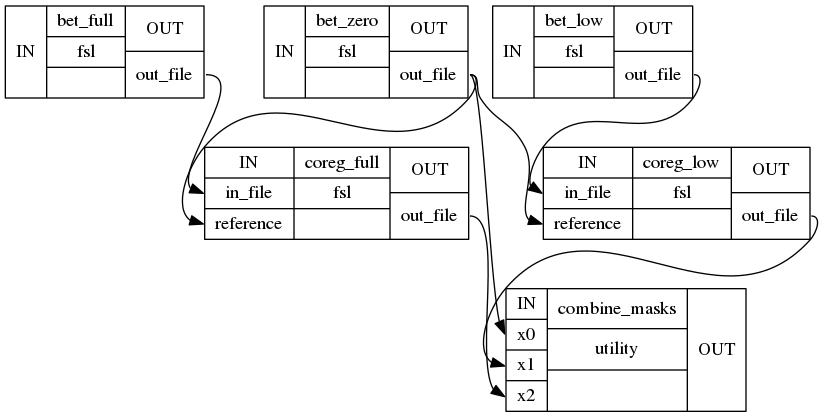

In [102]:
wf = nipype.Workflow(name='registration', base_dir=working_dir)
wf.connect([
    (bet_zero_node, coreg_low_node, [('out_file', 'reference')]), 
    (bet_low_node, coreg_low_node, [('out_file', 'in_file')]), 
    (bet_zero_node, coreg_full_node, [('out_file', 'reference')]), 
    (bet_full_node, coreg_full_node, [('out_file', 'in_file')]), 
    (bet_zero_node, combine_masks_node, [('out_file', 'x0')]), 
    (coreg_low_node, combine_masks_node, [('out_file', 'x1')]), 
    (coreg_full_node, combine_masks_node, [('out_file', 'x2')]), 
           ])

# wf.write_graph('workflow_graph.dot')
# Image(filename='{working_dir}/registration/workflow_graph.png'.format(working_dir=working_dir))

wf.write_graph(graph2use='flat')
Image(filename='{working_dir}/registration/graph_detailed.png'.format(working_dir=working_dir))

In [93]:
bet_zero_node.inputs.in_file = nib_files[0]
bet_low_node.inputs.in_file = nib_files[1]
bet_full_node.inputs.in_file = nib_files[2]

# wf.run()
wf.run(plugin='MultiProc', plugin_args={'n_procs' : 10})

190117-17:08:31,506 nipype.workflow INFO:
	 Workflow registration settings: ['check', 'execution', 'logging', 'monitoring']
190117-17:08:31,513 nipype.workflow INFO:
	 Running in parallel.
190117-17:08:31,516 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 226.65/226.65, Free processors: 10/10.
190117-17:08:31,652 nipype.workflow INFO:
	 [Job 0] Cached (registration.bet_zero).
190117-17:08:31,654 nipype.workflow INFO:
	 [Job 1] Cached (registration.bet_low).
190117-17:08:31,657 nipype.workflow INFO:
	 [Job 3] Cached (registration.bet_full).
190117-17:08:33,519 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 226.65/226.65, Free processors: 10/10.
190117-17:08:33,651 nipype.workflow INFO:
	 [Job 2] Cached (registration.coreg_low).
190117-17:08:33,655 nipype.workflow INFO:
	 [Job 4] Cached (registration.coreg_full).
190117-17:08:35,521 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Fr

RuntimeError: Workflow did not execute cleanly. Check log for details

Process Process-151:
Process Process-153:
Process Process-159:
Process Process-154:
Process Process-160:
Process Process-152:
Process Process-155:
Process Process-157:
Process Process-158:
Process Process-156:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/concurrent/futures/process.py", line 169, in _process_worker
    call_item = call_queue.get(block=True)
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/usr/lib/python

In [8]:
print(working_dir)
!tree /raid/jon/data_full_hoag/data/101_Id_066study -I '*js|*json|*html|*pklz|_report'


/raid/jon/data_full_hoag/data/101_Id_066study
/raid/jon/data_full_hoag/data/101_Id_066study
├── 13_sag_mprage_we_10_percent.nii.gz
├── 14_sag_mprage_we_post.nii.gz
├── 2_sag_mprage.nii.gz
└── registration
    ├── bet_full
    │   ├── 14_sag_mprage_we_post_brain.nii.gz
    │   └── command.txt
    ├── bet_low
    │   ├── 13_sag_mprage_we_10_percent_brain.nii.gz
    │   └── command.txt
    ├── bet_zero
    │   ├── 2_sag_mprage_brain.nii.gz
    │   └── command.txt
    ├── coreg_full
    │   ├── 14_sag_mprage_we_post_brain_flirt.mat
    │   ├── 14_sag_mprage_we_post_brain_flirt.nii.gz
    │   └── command.txt
    ├── coreg_low
    │   ├── 13_sag_mprage_we_10_percent_brain_flirt.mat
    │   ├── 13_sag_mprage_we_10_percent_brain_flirt.nii.gz
    │   └── command.txt
    ├── graph_detailed.dot
    ├── graph_detailed.png
    ├── graph.dot
    ├── graph.png
    ├── workflow_graph.dot
    └── workflow_graph.png

6 directories, 21 files


In [81]:
_x0 = nib.load('{}/registration/bet_zero/2_sag_mprage_brain.nii.gz'.format(working_dir))
_x1 = nib.load('{}/registration/coreg_low/13_sag_mprage_we_10_percent_brain_flirt.nii.gz'.format(working_dir))
_x2 = nib.load('{}/registration/coreg_full/14_sag_mprage_we_post_brain_flirt.nii.gz'.format(working_dir))
_x3 = nib.load('{}/registration/bet_full/14_sag_mprage_we_post_brain.nii.gz'.format(working_dir))

x0, x1, x2, x3 = [__x.get_fdata() for __x in (_x0, _x1, _x2, _x3)]


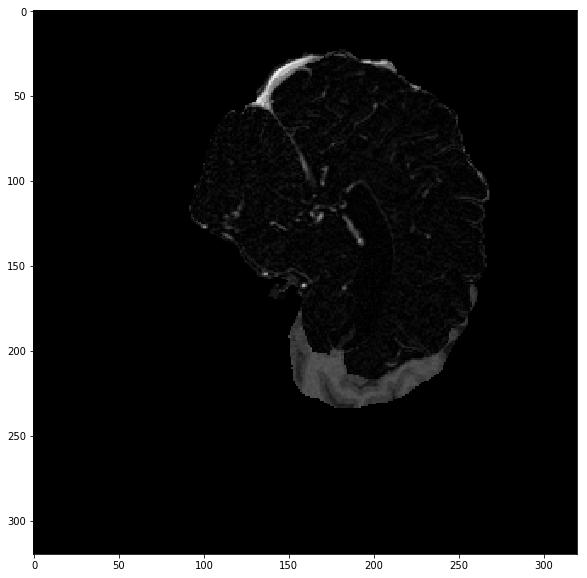

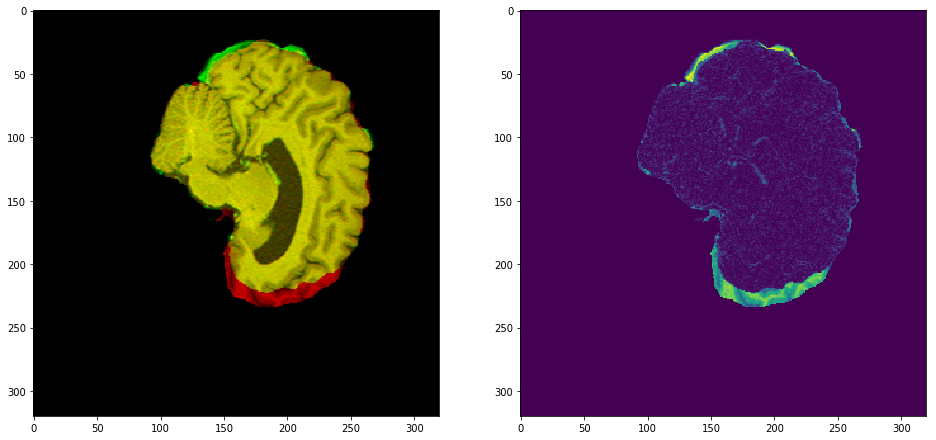

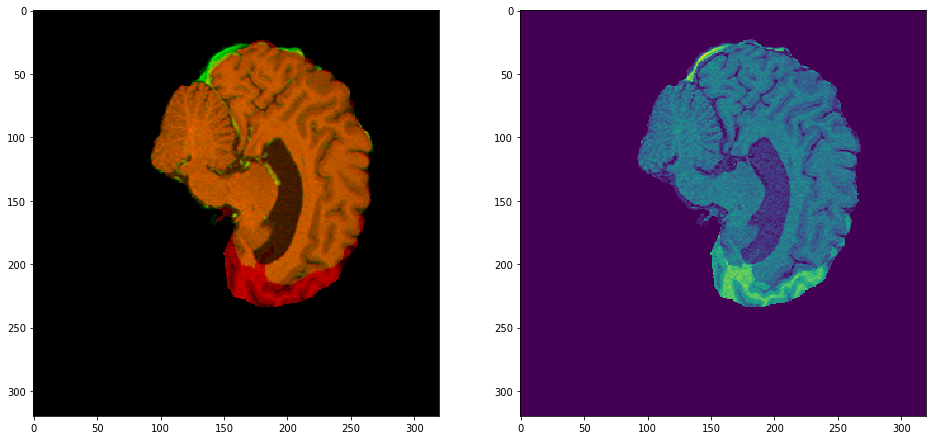

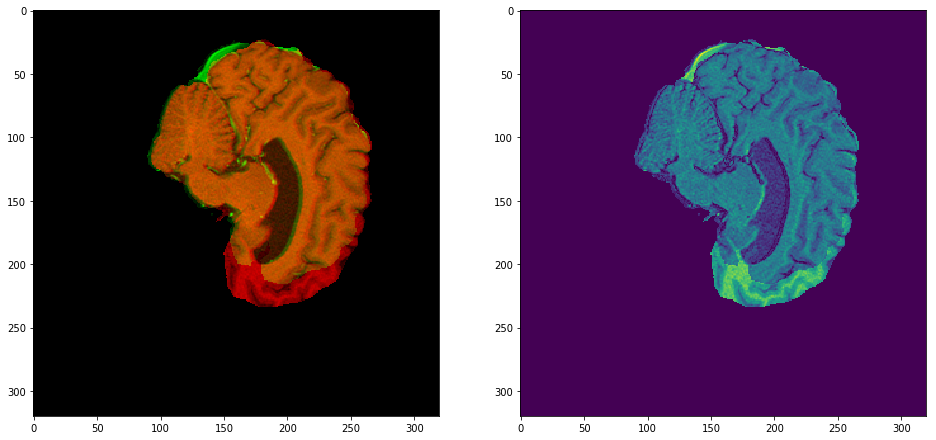

In [10]:
idx = 100

plt.figure(figsize=(16,10))
plt.imshow(abs(_x2.get_fdata()[idx,...] - _x0.get_fdata()[idx,...]), cmap='gray')

plt.figure(figsize=(16,10))
suplot.imshowreg(_x0.get_fdata()[idx,...], _x1.get_fdata()[idx,...])

plt.figure(figsize=(16,10))
suplot.imshowreg(_x0.get_fdata()[idx,...], _x2.get_fdata()[idx,...])

plt.figure(figsize=(16,10))
suplot.imshowreg(_x0.get_fdata()[idx,...], _x3.get_fdata()[idx,...])


## check if we can make single biggest brain mask

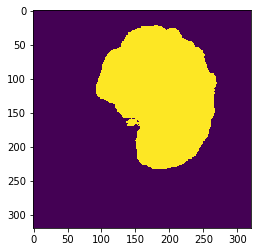

In [86]:
brain_mask = (x0+x1+x2) > 0
plt.imshow(brain_mask[idx,...])

## test kmeans to make enhancement mask 

In [15]:
from sklearn.cluster import KMeans

In [68]:
n = 5
idx_kmeans = np.arange(idx-20, idx+20)
X = np.stack((x0[idx_kmeans,...].ravel(), x1[idx_kmeans,...].ravel(), x2[idx_kmeans,...].ravel())).T
Xn = np.linalg.norm(X, axis=1)
print(X.shape)
X2 = X[Xn > 0.05*np.max(Xn)]
print(X2.shape)
kmeans = KMeans(n_clusters=n, random_state=723, n_jobs=10)
kmeans.fit(X2)

(4096000, 3)
(974986, 3)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=723, tol=0.0001, verbose=0)

(40, 320, 320)


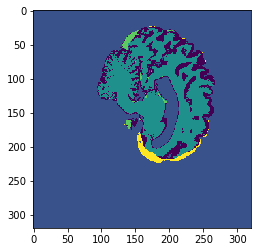

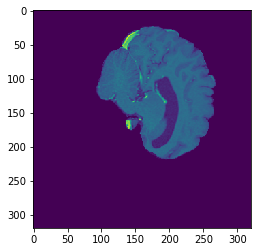

In [113]:
Y = kmeans.predict(X).reshape((x0[idx_kmeans,...].shape)).squeeze()
print(Y.shape)
_idx = 17
plt.imshow(Y[_idx,...])
plt.figure()
plt.imshow(x2[idx_kmeans[_idx],...].squeeze())